In [4]:
import matplotlib
import numpy as np
import os
import sys
%matplotlib inline
import matplotlib.pyplot as plt
from matplotlib import colors
import pickle
from glob import glob
from pprint import pprint
import poppy
import astropy.units as u
poppy.__version__

repo_dir = '/grad/bwedig/mejiro'
if repo_dir not in sys.path:
    sys.path.append(repo_dir)

# set matplotlib style
# plt.style.use(f'{repo_dir}/mejiro/mplstyle/science.mplstyle')

from mejiro.utils import util
from mejiro.instruments.hwo import HWO
from mejiro.instruments.roman import Roman
from mejiro.synthetic_image import SyntheticImage
from mejiro.galaxy_galaxy import SampleBELLS, SampleSL2S, SampleGG

Warning, 5 of 20000 bins contained negative fluxes; they have been set to zero.


/data/bwedig/.conda/envs/mejiro-v2/lib/python3.10/site-packages/pysynphot/units.py:824: RuntimeWarning: divide by zero encountered in log
  return -1.085736 * N.log(arg) + ABZERO


Warning, 3590 of 20000 bins contained negative fluxes; they have been set to zero.
Warning, 293 of 2920 bins contained negative fluxes; they have been set to zero.


In [14]:
hwo = HWO()
band = 'J'

pprint(f'pixel scale: {hwo.pixel_scale}')
pprint(f'aperture: {hwo.aperture}')
pprint(f'effective aperture: {hwo.effective_aperture}')

derived_bandpass = hwo.get_attribute_from_syotools(hwo.camera, 'derived_bandpass', None, False)
pprint(f'derived bandpass: {derived_bandpass}')

("pixel scale: {'FUV': <Quantity 0.00572958 arcsec / pix>, 'NUV': <Quantity "
 "0.00572958 arcsec / pix>, 'U': <Quantity 0.00572958 arcsec / pix>, 'B': "
 "<Quantity 0.00572958 arcsec / pix>, 'V': <Quantity 0.00572958 arcsec / pix>, "
 "'R': <Quantity 0.00572958 arcsec / pix>, 'I': <Quantity 0.00572958 arcsec / "
 "pix>, 'J': <Quantity 0.01718873 arcsec / pix>, 'H': <Quantity 0.01718873 "
 "arcsec / pix>, 'K': <Quantity 0.01718873 arcsec / pix>}")
'aperture: 7.2 m'
"effective aperture: ('JsonUnit', {'unit': 'm', 'value': 7.2})"
("derived bandpass: {'FUV': <Quantity 45. nm>, 'NUV': <Quantity 55. nm>, 'U': "
 "<Quantity 67.2 nm>, 'B': <Quantity 95. nm>, 'V': <Quantity 121.2 nm>, 'R': "
 "<Quantity 155. nm>, 'I': <Quantity 170. nm>, 'J': <Quantity 252. nm>, 'H': "
 "<Quantity 320. nm>, 'K': <Quantity 444. nm>}")


'wavelength: 2.5200000000000003e-07 m'


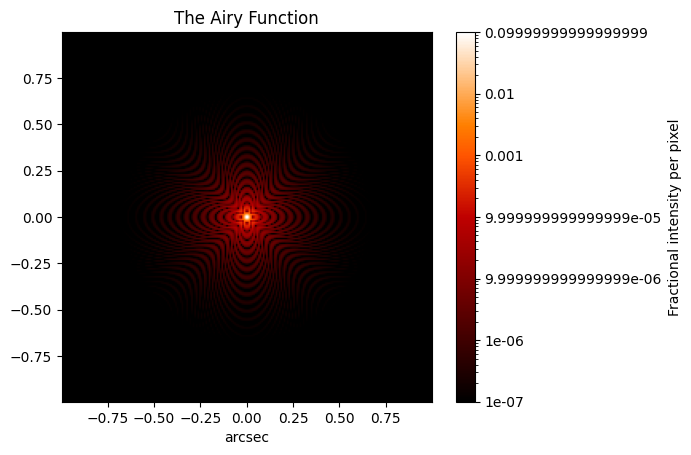

In [20]:
osys = poppy.OpticalSystem()
osys.add_pupil(poppy.CircularAperture(radius=hwo.aperture.value / 2))    # pupil radius in meters
osys.add_detector(pixelscale=hwo.get_pixel_scale(band).value, fov_arcsec=2.0)  # image plane coordinates in arcseconds

wavelength = derived_bandpass[band].to(u.m).value
pprint(f'wavelength: {wavelength} m')

psf = osys.calc_psf(wavelength)  # wavelength in microns
poppy.display_psf(psf, title='The Airy Function')

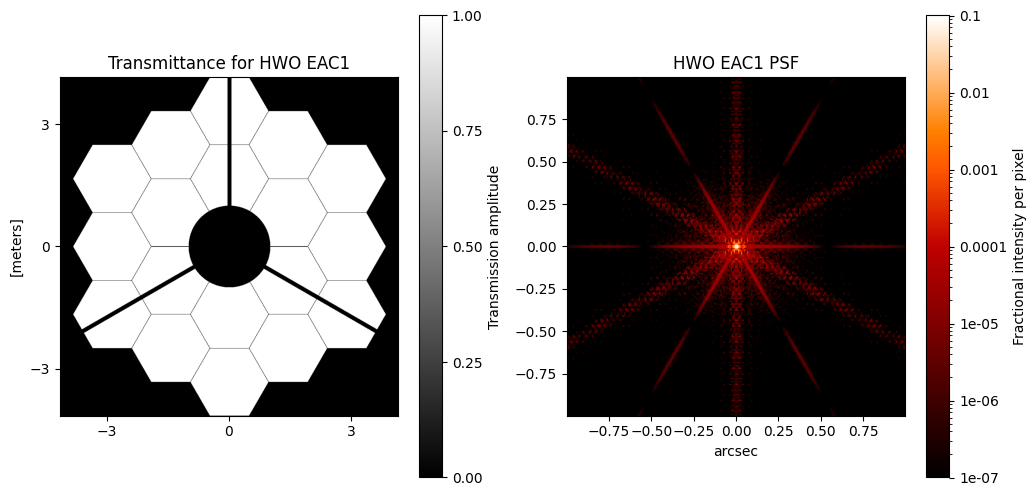

In [40]:
ap = poppy.MultiHexagonAperture(rings=2, flattoflat=1.65)
sec = poppy.SecondaryObscuration(secondary_radius=1., n_supports=3, support_width=0.1, support_angle_offset=90)
# sec = poppy.AsymmetricSecondaryObscuration(secondary_radius=0.3*u.m,
#                                              support_angle=(40, 140, 220, 320),
#                                              support_width=[0.05, 0.03, 0.03, 0.05],
#                                              support_offset_x=[0, -0.2, 0.2, 0],
#                                              name='Complex secondary')
atlast = poppy.CompoundAnalyticOptic( opticslist=[ap, sec], name='HWO EAC1')

osys = poppy.OpticalSystem()
osys.add_pupil(atlast)
osys.add_detector(pixelscale=hwo.get_pixel_scale(band).value, fov_arcsec=2.0)
psf = osys.calc_psf(wavelength)

_, ax = plt.subplots(1, 2, figsize=(12, 6))
atlast.display(ax=ax[0], npix=1024, colorbar_orientation='vertical')
poppy.display_psf(psf, title="HWO EAC1 PSF", ax=ax[1])
im = ax[1].images[0]
cbar = im.colorbar
if cbar is not None:
    cbar.set_ticks(cbar.get_ticks())
    cbar.set_ticklabels([f"{tick:.2g}" for tick in cbar.get_ticks()])
plt.show()